In [17]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

import pymc3 as pm
import theano.tensor as tt

from matplotlib import pylab as plt
import seaborn as sns

plt.style.use("bmh")

import arviz as az

%load_ext watermark
%matplotlib inline

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [2]:
%watermark -v -d -t -z -u -r -iv

sklearn          0.22
pandas           0.25.2
numpy            1.17.3
theano           1.0.4
matplotlib.pylab 1.17.3
seaborn          0.9.0
scipy            1.3.1
pymc3            3.8
arviz            0.6.0
last updated: 2019-12-27 10:15:34 PST 

CPython 3.7.4
IPython 7.9.0
Git repo: git@github.com:clausherther/nfl-analysis.git


In [3]:
SEED = 42

In [4]:
df = pd.read_hdf("data/field_goals.hd5", "field_goals")

In [5]:
df.columns

Index(['game_date', 'season_nbr', 'season_type_code', 'season_code', 'game_id',
       'play_id', 'quarter', 'home_team_code', 'away_team_code',
       'off_team_code', 'def_team_code', 'down', 'play_type', 'yards_to_go',
       'yardline_100', 'kicker_player_id', 'kicker_player_name',
       'is_within_goal_line', 'field_goal_result', 'is_field_goal_success',
       'field_goals', 'successful_field_goals'],
      dtype='object')

Baseline Field Goal % is:

In [6]:
df["successful_field_goals"].sum()/df["field_goals"].sum()

0.8338611090654687

In [7]:
def scale(x):
    return (x-x.mean())

In [254]:
yards_cutoff = 47
df_train = df.query(f"yardline_100 < {yards_cutoff}").copy()[
    ["yardline_100", "yards_to_go", "quarter", "season_type_code", "is_field_goal_success", "field_goals", "successful_field_goals"]
]
df_train.loc[:, "yardline_100_2"] = np.power(df_train["yardline_100"], 2)
df_train.loc[:, "is_fourth_quarter"] = df_train["quarter"].apply(lambda x: True if x == 4 else False)
df_train = pd.get_dummies(df_train, columns=["season_type_code"], )

feature_columns = ["yardline_100"]#, "yards_to_go", "is_fourth_quarter", "season_type_code_POST", "season_type_code_PRE"]

X = df_train[feature_columns].values

y = df_train["successful_field_goals"].values

In [255]:
df_train

,yardline_100,yards_to_go,quarter,is_field_goal_success,field_goals,successful_field_goals,yardline_100_2,is_fourth_quarter,season_type_code_POST,season_type_code_PRE,season_type_code_REG
0,2,2,2,True,1,1,4,False,0,1,0
1,29,7,2,True,1,1,841,False,0,1,0
2,34,9,3,True,1,1,1156,False,0,1,0
3,32,3,2,True,1,1,1024,False,0,1,0
4,11,10,2,True,1,1,121,False,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
13574,10,9,1,True,1,1,100,False,0,0,1
13575,6,6,2,True,1,1,36,False,0,0,1
13576,14,12,2,True,1,1,196,False,0,0,1
13577,28,16,2,True,1,1,784,False,0,0,1


In [256]:
X.shape, y.shape

((13565, 1), (13565,))

In [257]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [258]:
poly = PolynomialFeatures(1, include_bias=False)

In [259]:
clf = LogisticRegression(random_state=SEED).fit(X, y)

In [260]:
pipeline = make_pipeline(poly, clf)

In [261]:
pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=1, include_bias=False,
                                    interaction_only=False, order='C')),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [262]:
clf.intercept_, clf.coef_

(array([4.00638754]), array([[-0.10327504]]))

In [263]:
pipeline.score(X, y)

0.8371544415775893

In [264]:
y_pred = pipeline.predict(X)

In [265]:
np.sum(y_pred)/len(y_pred)

0.9834131957242904

In [266]:
metrics.r2_score(y, y_pred)

-0.18037063966256306

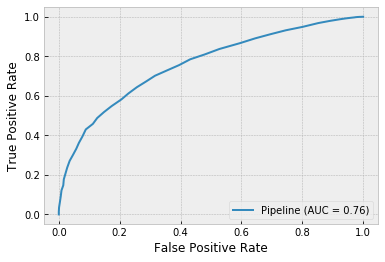

In [267]:
metrics.plot_roc_curve(pipeline, X, y);

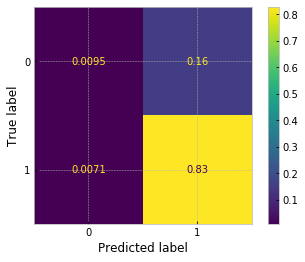

In [268]:
metrics.plot_confusion_matrix(pipeline, X, y, values_format=":,", normalize="all");

In [223]:
# y_pred_proba = pipeline.predict_proba(X)[:, 1]
# threshold_list = [0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95]

# _, axes = plt.subplots(3, 4, figsize=(18, 14))
# axes = axes.flatten()
# for i, t in enumerate(threshold_list):
#     ax = axes[i]
#     y_pred_ = np.array([1 if y > t else 0 for y in y_pred_proba])
#     test_accuracy = metrics.accuracy_score(y, y_pred_)
#     cfm = metrics.confusion_matrix(y, y_pred_, normalize="all")
#     sns.heatmap(cfm, cmap="GnBu", annot=True, cbar=False, ax=ax)
#     ax.set_title(f"T: {t:.2} A: {test_accuracy:.2%}")

In [269]:
df_train.loc[:, "y_pred"] = y_pred

In [270]:
df_grp_train = pd.DataFrame(
    df_train
     .groupby("yardline_100")[["field_goals", "successful_field_goals"]]
     .sum()
     .apply(lambda x: x["successful_field_goals"]/x["field_goals"], axis=1)
     .reset_index()
)
df_grp_train.columns = ["yardline_100", "field_goals_success_percent"]
df_grp_train.head()

,yardline_100,field_goals_success_percent
0,1,1.000000
1,2,0.992337
2,3,0.980132
3,4,0.981308
4,5,0.983914


In [271]:
x_yards = df_grp_train["yardline_100"].values
y_probs = df_grp_train["field_goals_success_percent"].values
# x_yards, y_probs

In [272]:
y_pred_prob = pipeline.predict_proba(x_yards.reshape(-1, 1))
y_pred_prob.shape

(46, 2)

In [1]:
_, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.scatter(x_yards, y_probs, label="observed")
# ax.plot("yardline_100", "field_goals_success_percent", data=df_grp_train, label="prediction", color="red", linestyle="dashed")
ax.plot(x_yards, y_pred_prob[:, 1], label="prediction", color="red", linestyle="dotted")
# ax = df_.plot.scatter(x="yardline_100", y="field_goals_success_percent", figsize=(15, 8))

vals = ax.get_yticks()
_ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
# ax.set_xscale("logit")

# reverse the x axis
ax.set_xlim(ax.get_xlim()[1], 0)
# ax.set_xticks(yard_lines_5)
# ax.set_xticklabels(yard_lines_5)
ax.set_xlabel("Yards from Goal Line")
ax.set_ylabel("Field Goal Success %")
ax.set_title("Field Goal Success % by Yard Line");

NameError: name 'plt' is not defined

In [274]:
n_chains = 3
n_cores = 3
n_draws = 4000
n_tunes = int(n_draws/2)

SEED = 42

SAMPLE_KWARGS = {
    "chains": n_chains,
    "cores": n_cores,
    "draws": n_draws,
    "tune": n_tunes,
    "target_accept": 0.95,
    "random_seed": [SEED+s for s in np.arange(0, n_chains)]
}
SAMPLE_KWARGS

{'chains': 3,
 'cores': 3,
 'draws': 4000,
 'tune': 2000,
 'target_accept': 0.95,
 'random_seed': [42, 43, 44]}

In [ ]:
df_grp_yards.info()

In [ ]:
X = df_train["yardline_100"]
y = df_train["successful_field_goals"]

In [ ]:
X.shape

In [ ]:
with pm.Model() as logit_model_1:
    
    alpha = pm.Normal("alpha", mu=0, sd=1)
#     beta = pm.StudentT("beta", nu=40, mu=0, sd=1)
    beta = pm.Normal("beta", mu=0, sd=1)


    mu = alpha + beta*X
    p = pm.Deterministic("p", pm.math.sigmoid(mu))
    bd = pm.Deterministic("bd", -alpha/beta)
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

In [ ]:
pm.model_to_graphviz(logit_model_1)

In [ ]:
with logit_model_1:
    logit_trace_1 = pm.sample(**SAMPLE_KWARGS)    

In [ ]:
clf.intercept_, clf.coef_

In [ ]:
az.plot_trace(logit_trace_1, combined=True, compact=True, var_names=["alpha", "beta"], divergences=None);

In [ ]:
logit_trace_1["alpha"].mean(), logit_trace_1["beta"].mean()

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.scatter(x_yards, y_probs, label="observed")
# ax.plot("yardline_100", "field_goals_success_percent", data=df_grp_train, label="prediction", color="red", linestyle="dashed")
# ax.plot(x_yards, y_pred_prob[:, 1], label="prediction", color="red", linestyle="dotted")
# ax = df_.plot.scatter(x="yardline_100", y="field_goals_success_percent", figsize=(15, 8))
az.plot_hpd(X, logit_trace_1["p"], color="red", credible_interval=.5, ax=ax, fill_kwargs={'alpha': .9})
az.plot_hpd(X, logit_trace_1["p"], color="C2", ax=ax, fill_kwargs={'alpha': .4})


vals = ax.get_yticks()
_ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
# ax.set_xscale("logit")

# reverse the x axis
# ax.set_xlim(ax.get_xlim()[1], 0)
# ax.set_xticks(yard_lines_5)
# ax.set_xticklabels(yard_lines_5)
ax.set_xlabel("Yards from Goal Line")
ax.set_ylabel("Field Goal Success %")
ax.set_title("Field Goal Success % by Yard Line");

In [ ]:
p = logit_trace_1["p"].mean(axis=0)
idx = np.argsort(X)
plt.plot(X, p);

In [ ]:
theta